In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [2]:
# Setting logging level
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

Loading the data of the [SLAC dataset](http://jmir.sourceforge.net/Codaich.html), with 250 MIDI files. The dataset is equally balanced over the classes.

The vectors are computed using [midi2vec](https://github.com/midi-ld/midi2vec).

The dataset provides 2 kind of classes (genres and subgenres), respectively of 5 and 10 elements:

- Blues
    - Modern Blues
    - Traditional Blues
- Classical
    - Baroque
    - Romantic
- Jazz
    - Bop
    - Swing
- Rap
    - Hardcore Rap
    - Pop Rap
- Rock
    - Alternative Rock
    - Metal

In [3]:
data = np.loadtxt('./dataset-slac/vectors.txt')
genres = np.loadtxt('./dataset-slac/genre.txt', dtype=np.str, delimiter=',')
subgenres = np.loadtxt('./dataset-slac/subgenre.txt', dtype=np.str, delimiter=',')

The labels are represented with the 1-hot encoding

In [4]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [5]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Experiment 1: Genres 

In [6]:
labels_1hot = onehot_labels(genres)
    
onehot2str(labels_1hot[0])

'Classical'

In [7]:
data.shape

(250, 100)

In [8]:
labels_1hot.shape

(250, 5)

In [9]:
num_input = data.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 5)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [10]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [11]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [12]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
225/225 [==============================] - 0s 726us/sample - loss: 0.4857 - acc: 0.7796
Epoch 2/100
225/225 [==============================] - 0s 51us/sample - loss: 0.2653 - acc: 0.9049
Epoch 3/100
225/225 [==============================] - 0s 60us/sample - loss: 0.1564 - acc: 0.9413
Epoch 4/100
225/225 [==============================] - 0s 48us/sample - loss: 0.0945 - acc: 0.9662
Epoch 5/100
225/225 [==============================] - 0s 47us/sample - loss: 0.0517 - acc: 0.9831
Epoch 6/100
225/225 [==============================] - 0s 49us/sample - loss: 0.0517 - acc: 0.9849
Epoch 7/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0255 - acc: 0.9929
Epoch 8/100
225/225 [==============================] - 0s 53us/sample - loss: 0.0162 - acc: 0.9964
Epoch 9/100
225/225 [==============================] - 0s 48us/sample - loss: 0.0086 - 

225/225 [==============================] - 0s 52us/sample - loss: 2.7312e-05 - acc: 1.0000
Epoch 75/100
225/225 [==============================] - 0s 48us/sample - loss: 2.6797e-05 - acc: 1.0000
Epoch 76/100
225/225 [==============================] - 0s 74us/sample - loss: 2.6180e-05 - acc: 1.0000
Epoch 77/100
225/225 [==============================] - 0s 64us/sample - loss: 2.5427e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 56us/sample - loss: 2.4879e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 55us/sample - loss: 2.4267e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 63us/sample - loss: 2.3777e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 61us/sample - loss: 2.3307e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 55us/sample - loss: 2.2868e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 70us/sample - loss

225/225 [==============================] - 0s 57us/sample - loss: 3.9913e-05 - acc: 1.0000
Epoch 53/100
225/225 [==============================] - 0s 54us/sample - loss: 3.8367e-05 - acc: 1.0000
Epoch 54/100
225/225 [==============================] - 0s 50us/sample - loss: 3.7191e-05 - acc: 1.0000
Epoch 55/100
225/225 [==============================] - 0s 51us/sample - loss: 3.6350e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 50us/sample - loss: 3.5164e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 51us/sample - loss: 3.3968e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 52us/sample - loss: 3.2769e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 53us/sample - loss: 3.1813e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 53us/sample - loss: 3.0895e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 60us/sample - loss

225/225 [==============================] - 0s 55us/sample - loss: 1.3222e-04 - acc: 1.0000
Epoch 31/100
225/225 [==============================] - 0s 53us/sample - loss: 1.1932e-04 - acc: 1.0000
Epoch 32/100
225/225 [==============================] - 0s 57us/sample - loss: 1.0887e-04 - acc: 1.0000
Epoch 33/100
225/225 [==============================] - 0s 51us/sample - loss: 1.0263e-04 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 52us/sample - loss: 9.6212e-05 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 56us/sample - loss: 9.1149e-05 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 53us/sample - loss: 8.6536e-05 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 56us/sample - loss: 8.2195e-05 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 55us/sample - loss: 7.8251e-05 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 59us/sample - loss

225/225 [==============================] - 0s 51us/sample - loss: 0.0200 - acc: 0.9973
Epoch 9/100
225/225 [==============================] - 0s 51us/sample - loss: 0.0108 - acc: 0.9973
Epoch 10/100
225/225 [==============================] - 0s 50us/sample - loss: 0.0063 - acc: 0.9991
Epoch 11/100
225/225 [==============================] - 0s 49us/sample - loss: 0.0044 - acc: 0.9991
Epoch 12/100
225/225 [==============================] - 0s 52us/sample - loss: 0.0034 - acc: 0.9991
Epoch 13/100
225/225 [==============================] - 0s 48us/sample - loss: 0.0026 - acc: 0.9991
Epoch 14/100
225/225 [==============================] - 0s 51us/sample - loss: 0.0021 - acc: 1.0000
Epoch 15/100
225/225 [==============================] - 0s 49us/sample - loss: 0.0016 - acc: 1.0000
Epoch 16/100
225/225 [==============================] - 0s 51us/sample - loss: 0.0014 - acc: 1.0000
Epoch 17/100
225/225 [==============================] - 0s 50us/sample - loss: 0.0011 - acc: 1.0000
Epoch 18/100
2

225/225 [==============================] - 0s 50us/sample - loss: 2.3469e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 51us/sample - loss: 2.3023e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 52us/sample - loss: 2.2510e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 51us/sample - loss: 2.2023e-05 - acc: 1.0000
Epoch 91/100
225/225 [==============================] - 0s 56us/sample - loss: 2.1464e-05 - acc: 1.0000
Epoch 92/100
225/225 [==============================] - 0s 52us/sample - loss: 2.0803e-05 - acc: 1.0000
Epoch 93/100
225/225 [==============================] - 0s 54us/sample - loss: 2.0227e-05 - acc: 1.0000
Epoch 94/100
225/225 [==============================] - 0s 50us/sample - loss: 1.9708e-05 - acc: 1.0000
Epoch 95/100
225/225 [==============================] - 0s 51us/sample - loss: 1.9278e-05 - acc: 1.0000
Epoch 96/100
225/225 [==============================] - 0s 48us/sample - loss

225/225 [==============================] - 0s 53us/sample - loss: 4.7863e-05 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 52us/sample - loss: 4.6464e-05 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 53us/sample - loss: 4.5168e-05 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 54us/sample - loss: 4.3796e-05 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 54us/sample - loss: 4.2603e-05 - acc: 1.0000
Epoch 70/100
225/225 [==============================] - 0s 56us/sample - loss: 4.1842e-05 - acc: 1.0000
Epoch 71/100
225/225 [==============================] - 0s 55us/sample - loss: 4.0363e-05 - acc: 1.0000
Epoch 72/100
225/225 [==============================] - 0s 55us/sample - loss: 3.9172e-05 - acc: 1.0000
Epoch 73/100
225/225 [==============================] - 0s 63us/sample - loss: 3.8369e-05 - acc: 1.0000
Epoch 74/100
225/225 [==============================] - 0s 56us/sample - loss

225/225 [==============================] - 0s 49us/sample - loss: 1.1206e-04 - acc: 1.0000
Epoch 44/100
225/225 [==============================] - 0s 52us/sample - loss: 1.0525e-04 - acc: 1.0000
Epoch 45/100
225/225 [==============================] - 0s 50us/sample - loss: 1.0194e-04 - acc: 1.0000
Epoch 46/100
225/225 [==============================] - 0s 51us/sample - loss: 9.6268e-05 - acc: 1.0000
Epoch 47/100
225/225 [==============================] - 0s 52us/sample - loss: 9.1907e-05 - acc: 1.0000
Epoch 48/100
225/225 [==============================] - 0s 60us/sample - loss: 8.7733e-05 - acc: 1.0000
Epoch 49/100
225/225 [==============================] - 0s 50us/sample - loss: 8.3613e-05 - acc: 1.0000
Epoch 50/100
225/225 [==============================] - 0s 52us/sample - loss: 8.0683e-05 - acc: 1.0000
Epoch 51/100
225/225 [==============================] - 0s 51us/sample - loss: 7.7358e-05 - acc: 1.0000
Epoch 52/100
225/225 [==============================] - 0s 52us/sample - loss

225/225 [==============================] - 0s 54us/sample - loss: 2.2115e-04 - acc: 1.0000
Epoch 22/100
225/225 [==============================] - 0s 56us/sample - loss: 2.2011e-04 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 55us/sample - loss: 2.2951e-04 - acc: 1.0000
Epoch 24/100
225/225 [==============================] - 0s 52us/sample - loss: 1.7213e-04 - acc: 1.0000
Epoch 25/100
225/225 [==============================] - 0s 54us/sample - loss: 1.5002e-04 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 53us/sample - loss: 1.3960e-04 - acc: 1.0000
Epoch 27/100
225/225 [==============================] - 0s 53us/sample - loss: 1.3312e-04 - acc: 1.0000
Epoch 28/100
225/225 [==============================] - 0s 54us/sample - loss: 1.6802e-04 - acc: 1.0000
Epoch 29/100
225/225 [==============================] - 0s 56us/sample - loss: 1.1091e-04 - acc: 1.0000
Epoch 30/100
225/225 [==============================] - 0s 53us/sample - loss

225/225 [==============================] - 0s 63us/sample - loss: 1.0515e-05 - acc: 1.0000
Epoch 100/100
25/25 [==============================] - 0s 4ms/sample - loss: 0.3486 - acc: 0.9200
Epoch 1/100
225/225 [==============================] - 0s 888us/sample - loss: 0.4880 - acc: 0.7716
Epoch 2/100
225/225 [==============================] - 0s 54us/sample - loss: 0.2549 - acc: 0.8933
Epoch 3/100
225/225 [==============================] - 0s 51us/sample - loss: 0.1534 - acc: 0.9324
Epoch 4/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0871 - acc: 0.9716
Epoch 5/100
225/225 [==============================] - 0s 54us/sample - loss: 0.0442 - acc: 0.9867
Epoch 6/100
225/225 [==============================] - 0s 60us/sample - loss: 0.0220 - acc: 0.9973
Epoch 7/100
225/225 [==============================] - 0s 50us/sample - loss: 0.0096 - acc: 0.9991
Epoch 8/100
225/225 [==============================] - 0s 55us/sample - loss: 0.0065 - acc: 0.9991
Epoch 9/100
225/22

225/225 [==============================] - 0s 56us/sample - loss: 2.1329e-05 - acc: 1.0000
Epoch 78/100
225/225 [==============================] - 0s 57us/sample - loss: 2.0787e-05 - acc: 1.0000
Epoch 79/100
225/225 [==============================] - 0s 56us/sample - loss: 2.0221e-05 - acc: 1.0000
Epoch 80/100
225/225 [==============================] - 0s 60us/sample - loss: 1.9761e-05 - acc: 1.0000
Epoch 81/100
225/225 [==============================] - 0s 72us/sample - loss: 1.9381e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 73us/sample - loss: 1.8789e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 67us/sample - loss: 1.8551e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 63us/sample - loss: 1.8046e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 59us/sample - loss: 1.7656e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 54us/sample - loss

225/225 [==============================] - 0s 58us/sample - loss: 5.9383e-05 - acc: 1.0000
Epoch 56/100
225/225 [==============================] - 0s 56us/sample - loss: 9.6092e-05 - acc: 1.0000
Epoch 57/100
225/225 [==============================] - 0s 59us/sample - loss: 5.1553e-05 - acc: 1.0000
Epoch 58/100
225/225 [==============================] - 0s 58us/sample - loss: 3.5462e-05 - acc: 1.0000
Epoch 59/100
225/225 [==============================] - 0s 56us/sample - loss: 3.4356e-05 - acc: 1.0000
Epoch 60/100
225/225 [==============================] - 0s 53us/sample - loss: 3.3687e-05 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 71us/sample - loss: 3.2261e-05 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 59us/sample - loss: 3.0941e-05 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 64us/sample - loss: 2.9850e-05 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 57us/sample - loss

225/225 [==============================] - 0s 60us/sample - loss: 7.4004e-05 - acc: 1.0000
Epoch 34/100
225/225 [==============================] - 0s 60us/sample - loss: 7.0112e-05 - acc: 1.0000
Epoch 35/100
225/225 [==============================] - 0s 56us/sample - loss: 6.7249e-05 - acc: 1.0000
Epoch 36/100
225/225 [==============================] - 0s 56us/sample - loss: 6.4262e-05 - acc: 1.0000
Epoch 37/100
225/225 [==============================] - 0s 51us/sample - loss: 6.1184e-05 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 57us/sample - loss: 5.8606e-05 - acc: 1.0000
Epoch 39/100
225/225 [==============================] - 0s 55us/sample - loss: 5.5994e-05 - acc: 1.0000
Epoch 40/100
225/225 [==============================] - 0s 52us/sample - loss: 5.3566e-05 - acc: 1.0000
Epoch 41/100
225/225 [==============================] - 0s 58us/sample - loss: 5.1453e-05 - acc: 1.0000
Epoch 42/100
225/225 [==============================] - 0s 64us/sample - loss

array([0.93599999, 0.88799995, 0.91199994, 0.91199994, 0.89600009,
       0.90399992, 0.92000002, 0.89599997, 1.        , 0.95199996])

In [13]:
np.mean(scores)

0.9215999782085419

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_1hot, test_size=0.15, random_state=42)

neural_network.fit(X_train, y_train, verbose=0)
predicted = neural_network.predict(X_test)

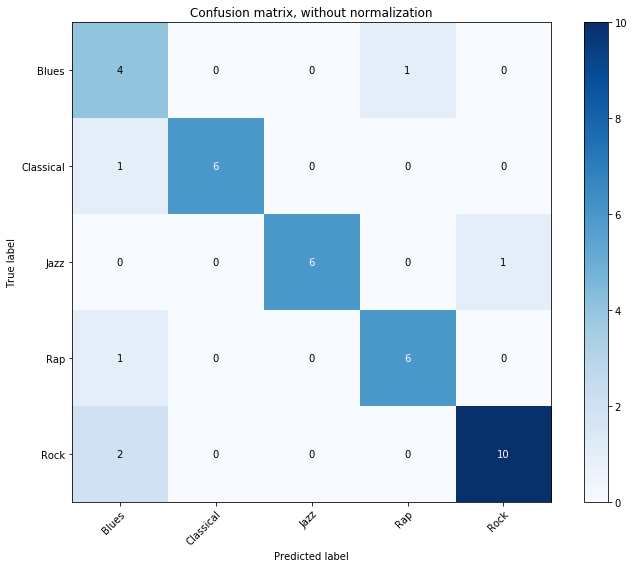

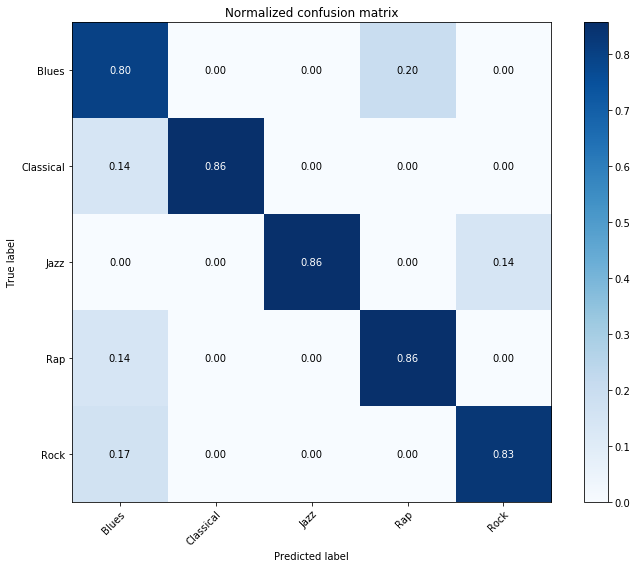

In [15]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, predicted, classes=genres,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test, predicted, classes=genres, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 2: Subgenres 

The experiment is the same, but applied to the 10 subgenre classes.

In [16]:
labels_1hot = onehot_labels(subgenres)
    
onehot2str(labels_1hot[0])

'Romantic'

In [17]:
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 10)

In [18]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [19]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

Epoch 1/100
225/225 [==============================] - 0s 993us/sample - loss: 0.4221 - acc: 0.8382
Epoch 2/100
225/225 [==============================] - 0s 58us/sample - loss: 0.2704 - acc: 0.9044
Epoch 3/100
225/225 [==============================] - 0s 58us/sample - loss: 0.2131 - acc: 0.9147
Epoch 4/100
225/225 [==============================] - 0s 70us/sample - loss: 0.1358 - acc: 0.9444
Epoch 5/100
225/225 [==============================] - 0s 56us/sample - loss: 0.0930 - acc: 0.9653
Epoch 6/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0693 - acc: 0.9751
Epoch 7/100
225/225 [==============================] - 0s 57us/sample - loss: 0.0432 - acc: 0.9880
Epoch 8/100
225/225 [==============================] - 0s 58us/sample - loss: 0.0316 - acc: 0.9911
Epoch 9/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0185 - acc: 0.9969
Epoch 10/100
225/225 [==============================] - 0s 58us/sample - loss: 0.0112 - acc: 0.9982
Epoch 11

Epoch 81/100
225/225 [==============================] - 0s 64us/sample - loss: 5.5348e-05 - acc: 1.0000
Epoch 82/100
225/225 [==============================] - 0s 66us/sample - loss: 4.9694e-05 - acc: 1.0000
Epoch 83/100
225/225 [==============================] - 0s 64us/sample - loss: 5.4462e-05 - acc: 1.0000
Epoch 84/100
225/225 [==============================] - 0s 61us/sample - loss: 4.7232e-05 - acc: 1.0000
Epoch 85/100
225/225 [==============================] - 0s 65us/sample - loss: 5.0029e-05 - acc: 1.0000
Epoch 86/100
225/225 [==============================] - 0s 61us/sample - loss: 4.5413e-05 - acc: 1.0000
Epoch 87/100
225/225 [==============================] - 0s 57us/sample - loss: 4.6109e-05 - acc: 1.0000
Epoch 88/100
225/225 [==============================] - 0s 78us/sample - loss: 4.3050e-05 - acc: 1.0000
Epoch 89/100
225/225 [==============================] - 0s 60us/sample - loss: 4.1870e-05 - acc: 1.0000
Epoch 90/100
225/225 [==============================] - 0s 59us/

225/225 [==============================] - 0s 70us/sample - loss: 1.6166e-04 - acc: 1.0000
Epoch 61/100
225/225 [==============================] - 0s 66us/sample - loss: 1.5502e-04 - acc: 1.0000
Epoch 62/100
225/225 [==============================] - 0s 59us/sample - loss: 1.4369e-04 - acc: 1.0000
Epoch 63/100
225/225 [==============================] - 0s 60us/sample - loss: 1.4239e-04 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 61us/sample - loss: 1.2822e-04 - acc: 1.0000
Epoch 65/100
225/225 [==============================] - 0s 67us/sample - loss: 1.2509e-04 - acc: 1.0000
Epoch 66/100
225/225 [==============================] - 0s 59us/sample - loss: 1.2410e-04 - acc: 1.0000
Epoch 67/100
225/225 [==============================] - 0s 60us/sample - loss: 1.2984e-04 - acc: 1.0000
Epoch 68/100
225/225 [==============================] - 0s 64us/sample - loss: 1.1351e-04 - acc: 1.0000
Epoch 69/100
225/225 [==============================] - 0s 60us/sample - loss

225/225 [==============================] - 0s 62us/sample - loss: 0.0101 - acc: 0.9987
Epoch 40/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0089 - acc: 0.9987
Epoch 41/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0084 - acc: 0.9987
Epoch 42/100
225/225 [==============================] - 0s 57us/sample - loss: 0.0078 - acc: 0.9996
Epoch 43/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0087 - acc: 0.9991
Epoch 44/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0078 - acc: 0.9996
Epoch 45/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0079 - acc: 0.9991
Epoch 46/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0079 - acc: 0.9991
Epoch 47/100
225/225 [==============================] - 0s 56us/sample - loss: 0.0080 - acc: 0.9991
Epoch 48/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0078 - acc: 0.9991
Epoch 49/100


225/225 [==============================] - 0s 56us/sample - loss: 8.3042e-04 - acc: 1.0000
Epoch 21/100
225/225 [==============================] - 0s 54us/sample - loss: 6.7457e-04 - acc: 1.0000
Epoch 22/100
225/225 [==============================] - 0s 60us/sample - loss: 6.9075e-04 - acc: 1.0000
Epoch 23/100
225/225 [==============================] - 0s 59us/sample - loss: 6.3748e-04 - acc: 1.0000
Epoch 24/100
225/225 [==============================] - 0s 55us/sample - loss: 5.1929e-04 - acc: 1.0000
Epoch 25/100
225/225 [==============================] - 0s 61us/sample - loss: 4.4985e-04 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 54us/sample - loss: 3.9653e-04 - acc: 1.0000
Epoch 27/100
225/225 [==============================] - 0s 64us/sample - loss: 3.5176e-04 - acc: 1.0000
Epoch 28/100
225/225 [==============================] - 0s 64us/sample - loss: 3.1717e-04 - acc: 1.0000
Epoch 29/100
225/225 [==============================] - 0s 56us/sample - loss

225/225 [==============================] - 0s 60us/sample - loss: 2.1986e-05 - acc: 1.0000
Epoch 99/100
225/225 [==============================] - 0s 58us/sample - loss: 2.0919e-05 - acc: 1.0000
Epoch 100/100
25/25 [==============================] - 0s 6ms/sample - loss: 0.6395 - acc: 0.8960
Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.4227 - acc: 0.8404
Epoch 2/100
225/225 [==============================] - 0s 86us/sample - loss: 0.2620 - acc: 0.9040
Epoch 3/100
225/225 [==============================] - 0s 65us/sample - loss: 0.1760 - acc: 0.9280
Epoch 4/100
225/225 [==============================] - 0s 64us/sample - loss: 0.1235 - acc: 0.9471
Epoch 5/100
225/225 [==============================] - 0s 60us/sample - loss: 0.0838 - acc: 0.9680
Epoch 6/100
225/225 [==============================] - 0s 63us/sample - loss: 0.0550 - acc: 0.9809
Epoch 7/100
225/225 [==============================] - 0s 66us/sample - loss: 0.0319 - acc: 0.9911
Epoch 8/100
225

225/225 [==============================] - 0s 70us/sample - loss: 0.0076 - acc: 0.9991
Epoch 79/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0074 - acc: 0.9996
Epoch 80/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0073 - acc: 0.9996
Epoch 81/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0074 - acc: 0.9996
Epoch 82/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0073 - acc: 0.9996
Epoch 83/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0073 - acc: 0.9996
Epoch 84/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0073 - acc: 0.9996
Epoch 85/100
225/225 [==============================] - 0s 66us/sample - loss: 0.0073 - acc: 0.9996
Epoch 86/100
225/225 [==============================] - 0s 66us/sample - loss: 0.0073 - acc: 0.9996
Epoch 87/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0073 - acc: 0.9996
Epoch 88/100


225/225 [==============================] - 0s 71us/sample - loss: 0.0171 - acc: 0.9973
Epoch 59/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0137 - acc: 0.9973
Epoch 60/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0150 - acc: 0.9973
Epoch 61/100
225/225 [==============================] - 0s 78us/sample - loss: 0.0131 - acc: 0.9978
Epoch 62/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0093 - acc: 0.9991
Epoch 63/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0014 - acc: 1.0000
Epoch 64/100
225/225 [==============================] - 0s 81us/sample - loss: 0.0042 - acc: 0.9987
Epoch 65/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0022 - acc: 0.9991
Epoch 66/100
225/225 [==============================] - 0s 74us/sample - loss: 8.6356e-04 - acc: 0.9996
Epoch 67/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0015 - acc: 0.9996
Epoch 68/

225/225 [==============================] - 0s 64us/sample - loss: 8.0431e-04 - acc: 1.0000
Epoch 38/100
225/225 [==============================] - 0s 58us/sample - loss: 0.0014 - acc: 0.9991
Epoch 39/100
225/225 [==============================] - 0s 57us/sample - loss: 0.0528 - acc: 0.9893
Epoch 40/100
225/225 [==============================] - 0s 65us/sample - loss: 0.0558 - acc: 0.9880
Epoch 41/100
225/225 [==============================] - 0s 58us/sample - loss: 0.0602 - acc: 0.9880
Epoch 42/100
225/225 [==============================] - 0s 60us/sample - loss: 0.0439 - acc: 0.9889
Epoch 43/100
225/225 [==============================] - 0s 68us/sample - loss: 0.0198 - acc: 0.9973
Epoch 44/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0221 - acc: 0.9964
Epoch 45/100
225/225 [==============================] - 0s 66us/sample - loss: 0.0201 - acc: 0.9964
Epoch 46/100
225/225 [==============================] - 0s 63us/sample - loss: 0.0180 - acc: 0.9982
Epoch 47/

225/225 [==============================] - 0s 59us/sample - loss: 0.0187 - acc: 0.9942
Epoch 19/100
225/225 [==============================] - 0s 58us/sample - loss: 0.0153 - acc: 0.9956
Epoch 20/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0066 - acc: 0.9982
Epoch 21/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0038 - acc: 0.9991
Epoch 22/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0047 - acc: 0.9982
Epoch 23/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0020 - acc: 0.9996
Epoch 24/100
225/225 [==============================] - 0s 66us/sample - loss: 0.0026 - acc: 0.9996
Epoch 25/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0013 - acc: 1.0000
Epoch 26/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0021 - acc: 0.9991
Epoch 27/100
225/225 [==============================] - 0s 67us/sample - loss: 0.0037 - acc: 0.9991
Epoch 28/100


225/225 [==============================] - 0s 63us/sample - loss: 2.9869e-05 - acc: 1.0000
Epoch 98/100
225/225 [==============================] - 0s 59us/sample - loss: 2.8024e-05 - acc: 1.0000
Epoch 99/100
225/225 [==============================] - 0s 62us/sample - loss: 2.7875e-05 - acc: 1.0000
Epoch 100/100
25/25 [==============================] - 0s 7ms/sample - loss: 0.5420 - acc: 0.9280
Epoch 1/100
225/225 [==============================] - 0s 1ms/sample - loss: 0.4624 - acc: 0.8076
Epoch 2/100
225/225 [==============================] - 0s 64us/sample - loss: 0.2834 - acc: 0.9013
Epoch 3/100
225/225 [==============================] - 0s 61us/sample - loss: 0.2110 - acc: 0.9151
Epoch 4/100
225/225 [==============================] - 0s 61us/sample - loss: 0.1500 - acc: 0.9400
Epoch 5/100
225/225 [==============================] - 0s 65us/sample - loss: 0.1093 - acc: 0.9538
Epoch 6/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0740 - acc: 0.9751
Epoch 7/10

225/225 [==============================] - 0s 71us/sample - loss: 0.0073 - acc: 0.9996
Epoch 78/100
225/225 [==============================] - 0s 70us/sample - loss: 0.0089 - acc: 0.9991
Epoch 79/100
225/225 [==============================] - 0s 72us/sample - loss: 0.0078 - acc: 0.9991
Epoch 80/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0076 - acc: 0.9991
Epoch 81/100
225/225 [==============================] - 0s 69us/sample - loss: 0.0073 - acc: 0.9996
Epoch 82/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0074 - acc: 0.9996
Epoch 83/100
225/225 [==============================] - 0s 57us/sample - loss: 0.0073 - acc: 0.9996
Epoch 84/100
225/225 [==============================] - 0s 62us/sample - loss: 0.0073 - acc: 0.9996
Epoch 85/100
225/225 [==============================] - 0s 64us/sample - loss: 0.0073 - acc: 0.9996
Epoch 86/100
225/225 [==============================] - 0s 61us/sample - loss: 0.0073 - acc: 0.9996
Epoch 87/100


225/225 [==============================] - 0s 76us/sample - loss: 0.0077 - acc: 0.9991
Epoch 59/100
225/225 [==============================] - 0s 76us/sample - loss: 0.0076 - acc: 0.9996
Epoch 60/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0074 - acc: 0.9996
Epoch 61/100
225/225 [==============================] - 0s 73us/sample - loss: 0.0074 - acc: 0.9996
Epoch 62/100
225/225 [==============================] - 0s 71us/sample - loss: 0.0074 - acc: 0.9996
Epoch 63/100
225/225 [==============================] - 0s 75us/sample - loss: 0.0075 - acc: 0.9996
Epoch 64/100
225/225 [==============================] - 0s 74us/sample - loss: 0.0074 - acc: 0.9996
Epoch 65/100
225/225 [==============================] - 0s 67us/sample - loss: 0.0074 - acc: 0.9996
Epoch 66/100
225/225 [==============================] - 0s 65us/sample - loss: 0.0081 - acc: 0.9991
Epoch 67/100
225/225 [==============================] - 0s 59us/sample - loss: 0.0087 - acc: 0.9991
Epoch 68/100


array([0.92, 0.92, 0.88, 0.9 , 0.93, 0.92, 0.89, 0.93, 0.93, 0.92])

In [20]:
np.mean(scores)

0.9131999850273133

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_1hot, test_size=0.15, random_state=42)
neural_network.fit(X_train, y_train, verbose=0)
predicted = neural_network.predict(X_test)

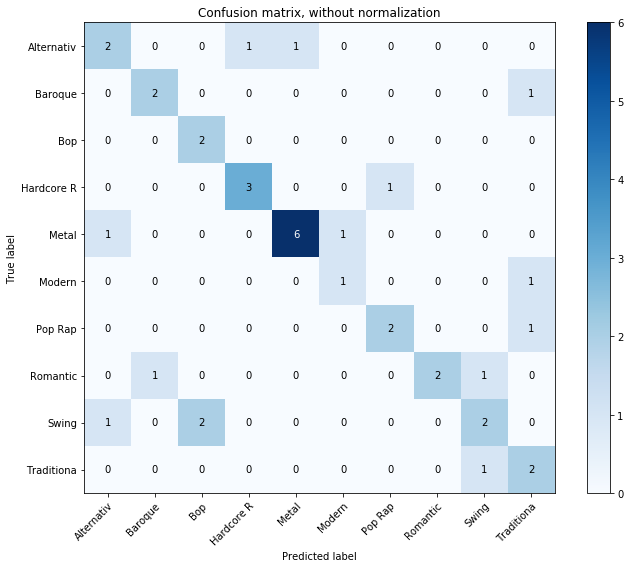

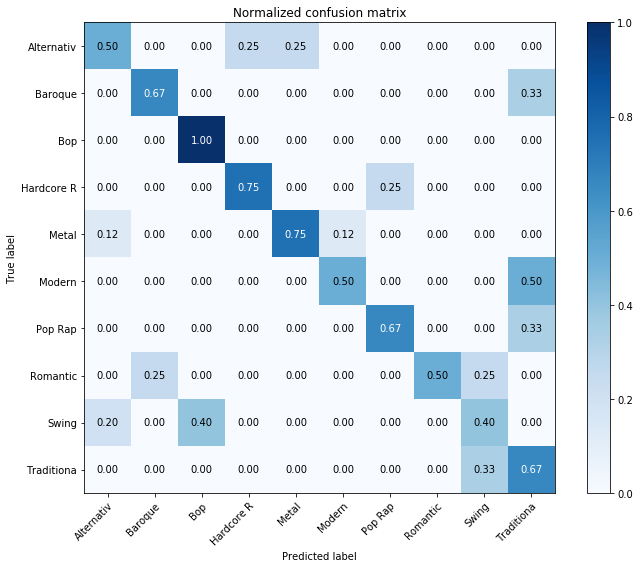

In [22]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, predicted, classes=subgenres,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test, predicted, classes=subgenres, normalize=True,
                      title='Normalized confusion matrix')